# Linear Regression: Gradient Descent with Regularization

## Introduction

In this notebook, we implement linear regression with gradient descent from scratch and extend it to include RIDGE (L2) and LASSO (L1) regularization techniques. We'll apply these implementations to predict house prices using the King County House Sales dataset.

**Author:** Your Name  
**Date:** May 2025

### Learning Objectives
- Implement gradient descent for multiple linear regression from scratch
- Apply regularization techniques (RIDGE and LASSO) to prevent overfitting
- Understand feature selection through LASSO regularization
- Visualize and interpret the results of different regularization methods


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set plot style
sns.set_style('whitegrid')
sns.set_palette('bright')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1. Theoretical Background

### 1.1 Linear Regression

Linear regression is a fundamental algorithm in machine learning that models the relationship between input features and the target variable by fitting a linear equation:

$$y = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$

Where:
- $y$ is the predicted value
- $x_1, x_2, ..., x_n$ are the input features
- $w_1, w_2, ..., w_n$ are the weights (coefficients)
- $b$ is the bias (intercept)

### 1.2 Regularization Techniques

Regularization adds a penalty term to the cost function to prevent overfitting.

1. **RIDGE Regression (L2 Regularization)**
   - Adds a penalty equal to the square of the magnitude of the coefficients
   - Cost function: $J(w) = \frac{1}{2m} \sum(y\_pred - y\_actual)^2 + \frac{\lambda}{2m} \sum w^2$
   - Tends to shrink coefficients toward zero but rarely makes them exactly zero

2. **LASSO Regression (L1 Regularization)**
   - Adds a penalty equal to the absolute value of the magnitude of the coefficients
   - Cost function: $J(w) = \frac{1}{2m} \sum(y\_pred - y\_actual)^2 + \frac{\lambda}{m} \sum |w|$
   - Can reduce some coefficients to exactly zero, effectively performing feature selection

## 2. Implementation

### 2.1 Data Preparation

In [2]:
def load_and_preprocess_data(file_path):
    """
    Load the dataset and perform preprocessing
    
    Args:
        file_path: Path to the dataset CSV file
        
    Returns:
        X_train: Training features (numpy array)
        y_train: Training target values (numpy array)
        X_test: Testing features (numpy array)
        y_test: Testing target values (numpy array)
    """
    # Load data using pandas
    df = pd.read_csv(file_path)
    
    # Select features for prediction (select at least 5 relevant features)
    # We choose features that likely have strong correlation with house prices
    features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above', 'view']
    X = df[features].values
    y = df['price'].values
    
    # Handle missing values (if necessary)
    # Check for NaN values
    if np.isnan(X).any():
        # Replace NaNs with feature means
        for col in range(X.shape[1]):
            mask = np.isnan(X[:, col])
            X[mask, col] = np.mean(X[~mask, col])
    
    # Normalize/standardize features
    # Compute mean and standard deviation for each feature
    feature_means = np.mean(X, axis=0)
    feature_stds = np.std(X, axis=0)
    
    # Standardize features (z-score normalization)
    X_normalized = (X - feature_means) / feature_stds
    
    # Split data into training (80%) and testing (20%) sets
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Shuffle data (create random indices)
    indices = np.random.permutation(X.shape[0])
    split_idx = int(X.shape[0] * 0.8)
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    # Split the data
    X_train = X_normalized[train_indices]
    y_train = y[train_indices]
    X_test = X_normalized[test_indices]
    y_test = y[test_indices]
    
    return X_train, y_train, X_test, y_test

### 2.2 Basic Linear Regression Functions

In [3]:
def predict(X, weights, bias):
    """
    Make predictions using the linear model: y = X*w + b
    
    Args:
        X: Features (numpy array)
        weights: Model weights (numpy array)
        bias: Model bias (scalar)
        
    Returns:
        Predicted values (numpy array)
    """
    return np.dot(X, weights) + bias

In [4]:
def compute_cost(X, y, weights, bias):
    """
    Compute the Mean Squared Error cost function
    
    Args:
        X: Features (numpy array)
        y: Target values (numpy array)
        weights: Model weights (numpy array)
        bias: Model bias (scalar)
        
    Returns:
        Mean Squared Error (scalar)
    """
    m = X.shape[0]  # Number of samples
    
    # Calculate predictions
    y_pred = predict(X, weights, bias)
    
    # Calculate the error (difference between predictions and actual values)
    error = y_pred - y
    
    # Calculate MSE: J(w) = (1/2m) * Σ(y_pred - y_actual)²
    cost = (1 / (2 * m)) * np.sum(error ** 2)
    
    return cost

In [5]:
def gradient_descent(X, y, learning_rate, num_iterations):
    """
    Implement gradient descent algorithm for linear regression
    
    Args:
        X: Features (numpy array)
        y: Target values (numpy array)
        learning_rate: Learning rate alpha (scalar)
        num_iterations: Number of iterations to run (scalar)
        
    Returns:
        weights: Optimized weights (numpy array)
        bias: Optimized bias (scalar)
        cost_history: History of cost values during optimization (numpy array)
        weights_history: History of weights during optimization (numpy array)
        bias_history: History of bias during optimization (numpy array)
    """
    # Initialize parameters
    m, n = X.shape  # m = number of samples, n = number of features
    weights = np.zeros(n)
    bias = 0
    
    # Arrays to store history
    cost_history = np.zeros(num_iterations)
    weights_history = np.zeros((num_iterations, n))
    bias_history = np.zeros(num_iterations)
    
    # Implement gradient descent algorithm
    for i in range(num_iterations):
        # Calculate predictions
        y_pred = predict(X, weights, bias)
        
        # Calculate errors
        error = y_pred - y
        
        # Calculate gradients
        # ∂J/∂w = (1/m) * X^T * (y_pred - y)
        dw = (1 / m) * np.dot(X.T, error)
        # ∂J/∂b = (1/m) * Σ(y_pred - y)
        db = (1 / m) * np.sum(error)
        
        # Update parameters
        weights = weights - learning_rate * dw
        bias = bias - learning_rate * db
        
        # Store parameters and cost
        weights_history[i] = weights
        bias_history[i] = bias
        cost_history[i] = compute_cost(X, y, weights, bias)
    
    return weights, bias, cost_history, weights_history, bias_history

### 2.3 RIDGE Regression (L2 Regularization)

In [6]:
def compute_cost_ridge(X, y, weights, bias, lambda_param):
    """
    Compute the Mean Squared Error cost function with L2 regularization
    
    Args:
        X: Features (numpy array)
        y: Target values (numpy array)
        weights: Model weights (numpy array)
        bias: Model bias (scalar)
        lambda_param: Regularization parameter (scalar)
        
    Returns:
        Mean Squared Error with L2 regularization (scalar)
    """
    m = X.shape[0]  # Number of samples
    
    # Calculate predictions
    y_pred = predict(X, weights, bias)
    
    # Calculate the error (difference between predictions and actual values)
    error = y_pred - y
    
    # Calculate MSE with L2 regularization:
    # J(w) = (1/2m) * Σ(y_pred - y_actual)² + (λ/2m) * Σw²
    cost = (1 / (2 * m)) * np.sum(error ** 2) + (lambda_param / (2 * m)) * np.sum(weights ** 2)
    
    return cost

In [7]:
def gradient_descent_ridge(X, y, learning_rate, num_iterations, lambda_param):
    """
    Implement gradient descent algorithm for RIDGE regression
    
    Args:
        X: Features (numpy array)
        y: Target values (numpy array)
        learning_rate: Learning rate alpha (scalar)
        num_iterations: Number of iterations to run (scalar)
        lambda_param: Regularization parameter (scalar)
        
    Returns:
        weights: Optimized weights (numpy array)
        bias: Optimized bias (scalar)
        cost_history: History of cost values during optimization (numpy array)
        weights_history: History of weights during optimization (numpy array)
        bias_history: History of bias during optimization (numpy array)
    """
    # Initialize parameters
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    
    # Arrays to store history
    cost_history = np.zeros(num_iterations)
    weights_history = np.zeros((num_iterations, n))
    bias_history = np.zeros(num_iterations)
    
    # Implement gradient descent algorithm with RIDGE regularization
    for i in range(num_iterations):
        # Calculate predictions
        y_pred = predict(X, weights, bias)
        
        # Calculate errors
        error = y_pred - y
        
        # Calculate gradients with L2 regularization term
        # ∂J/∂w = (1/m) * X^T * (y_pred - y) + (λ/m) * w
        dw = (1 / m) * np.dot(X.T, error) + (lambda_param / m) * weights
        
        # Bias is not regularized
        # ∂J/∂b = (1/m) * Σ(y_pred - y)
        db = (1 / m) * np.sum(error)
        
        # Update parameters
        weights = weights - learning_rate * dw
        bias = bias - learning_rate * db
        
        # Store parameters and cost
        weights_history[i] = weights
        bias_history[i] = bias
        cost_history[i] = compute_cost_ridge(X, y, weights, bias, lambda_param)
    
    return weights, bias, cost_history, weights_history, bias_history

### 2.4 LASSO Regression (L1 Regularization)

In [8]:
def compute_cost_lasso(X, y, weights, bias, lambda_param):
    """
    Compute the Mean Squared Error cost function with L1 regularization
    
    Args:
        X: Features (numpy array)
        y: Target values (numpy array)
        weights: Model weights (numpy array)
        bias: Model bias (scalar)
        lambda_param: Regularization parameter (scalar)
        
    Returns:
        Mean Squared Error with L1 regularization (scalar)
    """
    m = X.shape[0]  # Number of samples
    
    # Calculate predictions
    y_pred = predict(X, weights, bias)
    
    # Calculate the error (difference between predictions and actual values)
    error = y_pred - y
    
    # Calculate MSE with L1 regularization:
    # J(w) = (1/2m) * Σ(y_pred - y_actual)² + (λ/m) * Σ|w|
    cost = (1 / (2 * m)) * np.sum(error ** 2) + (lambda_param / m) * np.sum(np.abs(weights))
    
    return cost

In [9]:
def gradient_descent_lasso(X, y, learning_rate, num_iterations, lambda_param):
    """
    Implement gradient descent algorithm for LASSO regression
    
    Args:
        X: Features (numpy array)
        y: Target values (numpy array)
        learning_rate: Learning rate alpha (scalar)
        num_iterations: Number of iterations to run (scalar)
        lambda_param: Regularization parameter (scalar)
        
    Returns:
        weights: Optimized weights (numpy array)
        bias: Optimized bias (scalar)
        cost_history: History of cost values during optimization (numpy array)
        weights_history: History of weights during optimization (numpy array)
        bias_history: History of bias during optimization (numpy array)
    """
    # Initialize parameters
    m, n = X.shape
    weights = np.zeros(n)
    bias = 0
    
    # Arrays to store history
    cost_history = np.zeros(num_iterations)
    weights_history = np.zeros((num_iterations, n))
    bias_history = np.zeros(num_iterations)
    
    # Implement gradient descent algorithm with LASSO regularization
    for i in range(num_iterations):
        # Calculate predictions
        y_pred = predict(X, weights, bias)
        
        # Calculate errors
        error = y_pred - y
        
        # Calculate gradient of MSE part
        dw_mse = (1 / m) * np.dot(X.T, error)
        
        # Calculate LASSO regularization term (subgradient)
        # ∂J/∂w = (1/m) * X^T * (y_pred - y) + (λ/m) * sign(w)
        # sign(w) is +1 for w > 0, -1 for w < 0, and 0 for w = 0
        dw_lasso = (lambda_param / m) * np.sign(weights)
        
        # Combine MSE gradient and LASSO regularization
        dw = dw_mse + dw_lasso
        
        # Bias is not regularized
        # ∂J/∂b = (1/m) * Σ(y_pred - y)
        db = (1 / m) * np.sum(error)
        
        # Update parameters
        weights = weights - learning_rate * dw
        bias = bias - learning_rate * db
        
        # Store parameters and cost
        weights_history[i] = weights
        bias_history[i] = bias
        cost_history[i] = compute_cost_lasso(X, y, weights, bias, lambda_param)
    
    return weights, bias, cost_history, weights_history, bias_history

### 2.5 Analysis and Visualization Functions

In [10]:
def evaluate_model(X, y, weights, bias, model_name):
    """
    Evaluate the model on the provided data
    
    Args:
        X: Features (numpy array)
        y: Target values (numpy array)
        weights: Model weights (numpy array)
        bias: Model bias (scalar)
        model_name: Name of the model for printing (string)
        
    Returns:
        Mean Squared Error (scalar)
    """
    y_pred = predict(X, weights, bias)
    mse = np.mean((y_pred - y) ** 2)
    print(f"{model_name} MSE: {mse:.4f}")
    return mse

In [11]:
def plot_cost_history(cost_history, title):
    """
    Plot the cost history over iterations
    
    Args:
        cost_history: History of cost values (numpy array)
        title: Plot title (string)
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(cost_history)), cost_history, linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Cost (MSE)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Highlighting initial and final costs
    plt.annotate(f'Initial cost: {cost_history[0]:.2f}', 
                 xy=(0, cost_history[0]),
                 xytext=(50, 20),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->'))
    
    plt.annotate(f'Final cost: {cost_history[-1]:.2f}', 
                 xy=(len(cost_history)-1, cost_history[-1]),
                 xytext=(-50, -20),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->'))
    
    plt.tight_layout()
    plt.show()

In [12]:
def plot_coefficients(feature_names, basic_weights, ridge_weights, lasso_weights):
    """
    Plot the coefficients from different models for comparison
    
    Args:
        feature_names: Names of the features (list)
        basic_weights: Weights from basic linear regression (numpy array)
        ridge_weights: Weights from RIDGE regression (numpy array)
        lasso_weights: Weights from LASSO regression (numpy array)
    """
    plt.figure(figsize=(14, 8))
    x = np.arange(len(feature_names))
    width = 0.25
    
    # Create the bars
    plt.bar(x - width, basic_weights, width, label='Basic', color='#3498db', alpha=0.7)
    plt.bar(x, ridge_weights, width, label='RIDGE', color='#2ecc71', alpha=0.7)
    plt.bar(x + width, lasso_weights, width, label='LASSO', color='#e74c3c', alpha=0.7)
    
    # Customize the plot
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Coefficient Value', fontsize=14)
    plt.title('Comparison of Model Coefficients', fontsize=16)
    plt.xticks(x, feature_names, rotation=45, ha='right', fontsize=12)
    plt.legend(fontsize=12)
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add grid lines for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [13]:
def plot_predictions(X_test, y_test, basic_weights, basic_bias, 
                   ridge_weights, ridge_bias, lasso_weights, lasso_bias):
    """
    Plot the predictions from different models against actual values
    
    Args:
        X_test: Test features (numpy array)
        y_test: Test target values (numpy array)
        basic_weights, basic_bias: Parameters for basic linear regression
        ridge_weights, ridge_bias: Parameters for RIDGE regression
        lasso_weights, lasso_bias: Parameters for LASSO regression
    """
    # Generate predictions for all models
    basic_pred = predict(X_test, basic_weights, basic_bias)
    ridge_pred = predict(X_test, ridge_weights, ridge_bias)
    lasso_pred = predict(X_test, lasso_weights, lasso_bias)
    
    # Sample a subset of test data for clearer visualization (50 points)
    sample_size = 50
    indices = np.random.choice(len(y_test), sample_size, replace=False)
    
    # Sort indices by actual values for better visualization
    indices = indices[np.argsort(y_test[indices])]
    
    # Get the sampled data
    actual = y_test[indices]
    basic_sampled = basic_pred[indices]
    ridge_sampled = ridge_pred[indices]
    lasso_sampled = lasso_pred[indices]
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Plot actual values
    plt.plot(range(sample_size), actual, 'o-', label='Actual', linewidth=2, color='black')
    
    # Plot predictions
    plt.plot(range(sample_size), basic_sampled, 's--', label='Basic Linear Regression', alpha=0.7, color='#3498db')
    plt.plot(range(sample_size), ridge_sampled, '^--', label='RIDGE Regression', alpha=0.7, color='#2ecc71')
    plt.plot(range(sample_size), lasso_sampled, 'd--', label='LASSO Regression', alpha=0.7, color='#e74c3c')
    
    plt.title('Model Predictions vs Actual Values', fontsize=16)
    plt.xlabel('Sample Index (sorted by actual value)', fontsize=14)
    plt.ylabel('House Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_model_comparison(basic_mse, ridge_mse, lasso_mse):
    """
    Plot a comparison of MSE values from different models
    
    Args:
        basic_mse: MSE from basic linear regression (scalar)
        ridge_mse: MSE from RIDGE regression (scalar)
        lasso_mse: MSE from LASSO regression (scalar)
    """
    models = ['Basic Linear\nRegression', 'RIDGE\nRegression', 'LASSO\nRegression']
    mse_values = [basic_mse, ridge_mse, lasso_mse]
    
    # Create color map based on performance (lower is better)
    colors = ['#e74c3c', '#f39c12', '#2ecc71']
    color_indices = np.argsort(np.argsort(mse_values))
    bar_colors = [colors[idx] for idx in color_indices]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, mse_values, color=bar_colors, alpha=0.7)
    
    # Add value labels on top of each bar
    for bar, value in zip(bars, mse_values):
        plt.text(bar.get_x() + bar.get_width()/2, 
                 value + max(mse_values) * 0.01,
                 f'{value:.2f}', 
                 ha='center', va='bottom', 
                 fontweight='bold')
    
    plt.title('Mean Squared Error Comparison', fontsize=16)
    plt.ylabel('Mean Squared Error', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [15]:
# This notebook is designed to run in Kaggle which has the dataset available via:
# ../input/housesalesprediction/kc_house_data.csv
# If you're running locally, update this path accordingly

# Use the special Kaggle input path
DATA_PATH = "../input/housesalesprediction/kc_house_data.csv"

## 3. Data Exploration and Preprocessing

In this section, we'll explore the King County House Sales dataset, 
understand its structure, and prepare it for our regression models.

Dataset description:
- This dataset contains house sale prices for King County, which includes Seattle
- It includes homes sold between May 2014 and May 2015
- The dataset contains various features like number of bedrooms, bathrooms, square footage, etc.

In [16]:
# Load the dataset
df = pd.read_csv(DATA_PATH)

In [17]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (21613, 21)

First 5 rows:


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [18]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [19]:
# Get statistical summary of numerical features
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


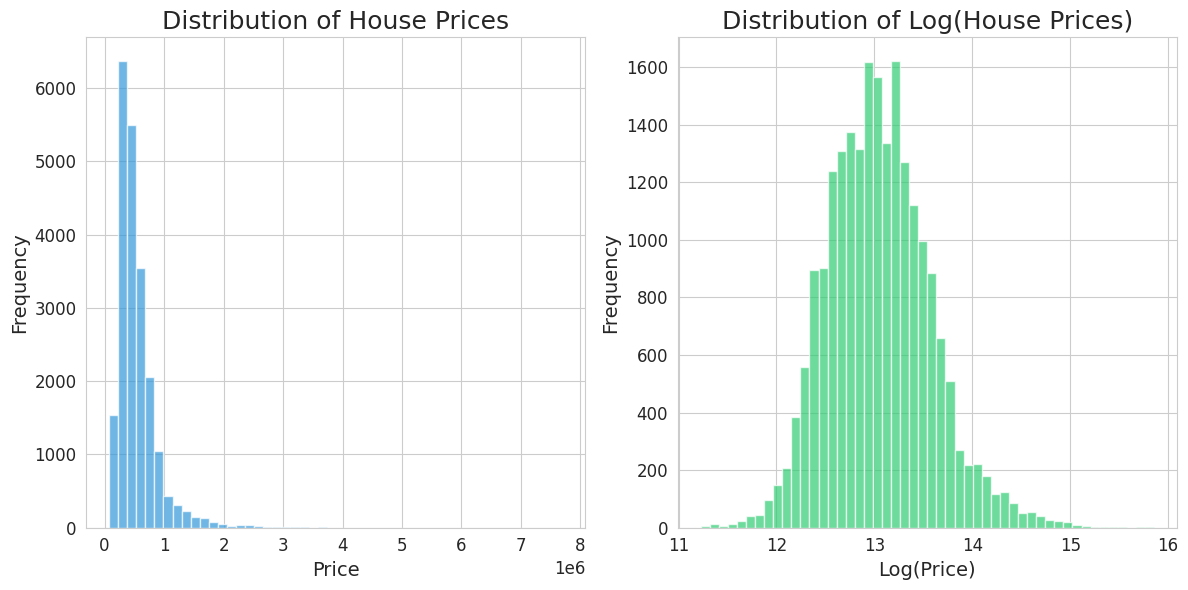

In [20]:
# Explore the target variable (price)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=50, color='#3498db', alpha=0.7)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(np.log(df['price']), bins=50, color='#2ecc71', alpha=0.7)
plt.title('Distribution of Log(House Prices)')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Correlation with price:
price          1.000000
sqft_living    0.702035
grade          0.667434
sqft_above     0.605567
bathrooms      0.525138
view           0.397293
bedrooms       0.308350
floors         0.256794
Name: price, dtype: float64


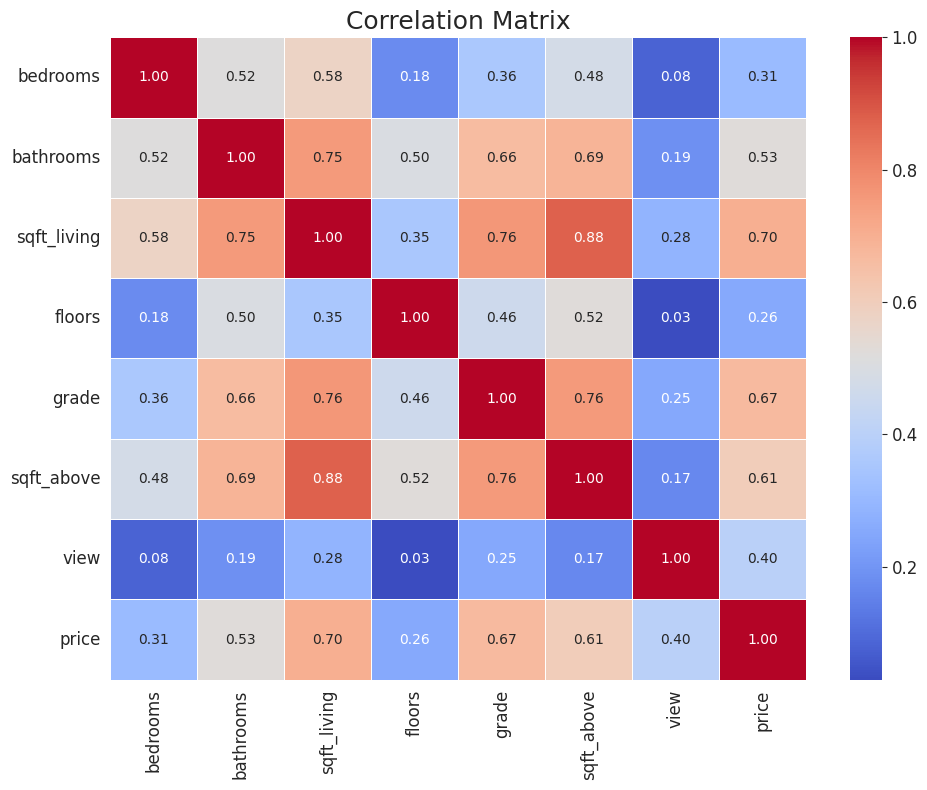

In [21]:
# Select features for our model
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above', 'view']

# Calculate correlation with price
correlation_with_price = df[features + ['price']].corr()['price'].sort_values(ascending=False)
print("\nCorrelation with price:")
print(correlation_with_price)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[features + ['price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

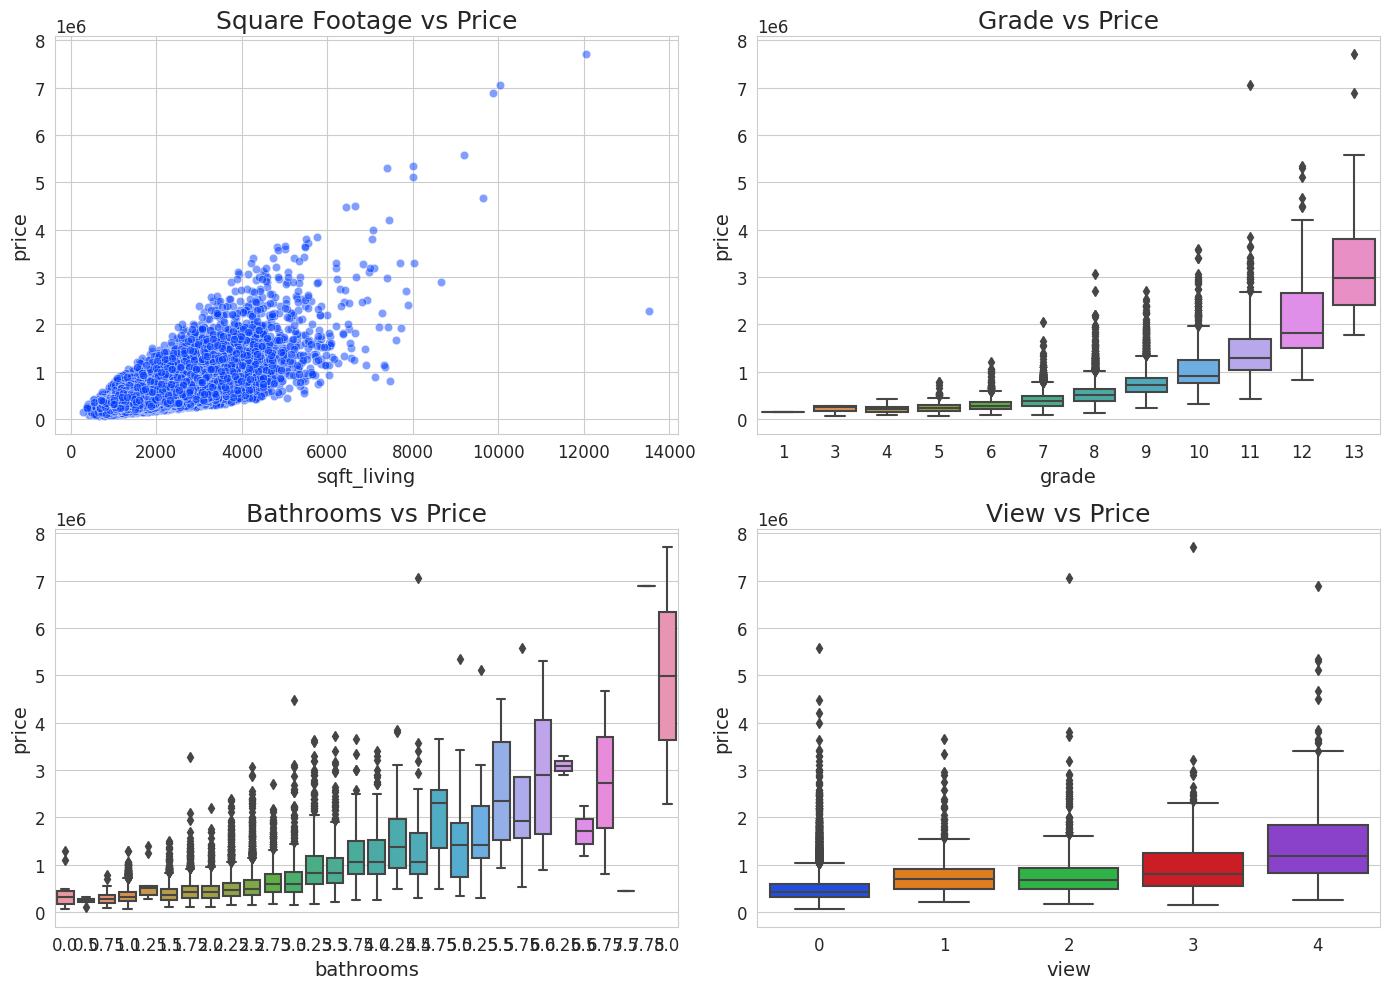

In [22]:
# Explore relationships between key features and price
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot sqft_living vs price
sns.scatterplot(x='sqft_living', y='price', data=df, alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title('Square Footage vs Price')

# Plot grade vs price
sns.boxplot(x='grade', y='price', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Grade vs Price')

# Plot bathrooms vs price
sns.boxplot(x='bathrooms', y='price', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Bathrooms vs Price')

# Plot view vs price
sns.boxplot(x='view', y='price', data=df, ax=axes[1, 1])
axes[1, 1].set_title('View vs Price')

plt.tight_layout()
plt.show()

## 4. Model Training and Evaluation

In [23]:
# Now let's preprocess the data and train our models
print("Preprocessing data and splitting into train/test sets...")

# Preprocess the data
X_train, y_train, X_test, y_test = load_and_preprocess_data(DATA_PATH)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Preprocessing data and splitting into train/test sets...
Training set shape: (17290, 7) (17290,)
Testing set shape: (4323, 7) (4323,)


In [24]:
# Define feature names for visualization
feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above', 'view']

# Set hyperparameters
learning_rate = 0.01
num_iterations = 1000
ridge_lambda = 0.1
lasso_lambda = 0.01

# Train Basic Linear Regression model
print("\nTraining Basic Linear Regression model...")
basic_weights, basic_bias, basic_cost_history, _, _ = gradient_descent(
    X_train, y_train, learning_rate, num_iterations
)

# Print the final weights and bias
print("\nBasic Linear Regression Model:")
print(f"Bias: {basic_bias:.4f}")
for name, weight in zip(feature_names, basic_weights):
    print(f"Weight for {name}: {weight:.6f}")

# Train RIDGE Regression model
print("\nTraining RIDGE Regression model...")
ridge_weights, ridge_bias, ridge_cost_history, _, _ = gradient_descent_ridge(
    X_train, y_train, learning_rate, num_iterations, ridge_lambda
)

# Print the final weights and bias
print("\nRIDGE Regression Model:")
print(f"Bias: {ridge_bias:.4f}")
for name, weight in zip(feature_names, ridge_weights):
    print(f"Weight for {name}: {weight:.6f}")

# Train LASSO Regression model
print("\nTraining LASSO Regression model...")
lasso_weights, lasso_bias, lasso_cost_history, _, _ = gradient_descent_lasso(
    X_train, y_train, learning_rate, num_iterations, lasso_lambda
)

# Print the final weights and bias
print("\nLASSO Regression Model:")
print(f"Bias: {lasso_bias:.4f}")
for name, weight in zip(feature_names, lasso_weights):
    print(f"Weight for {name}: {weight:.6f}")


Training Basic Linear Regression model...

Basic Linear Regression Model:
Bias: 540162.3174
Weight for bedrooms: -25861.305684
Weight for bathrooms: 144.702110
Weight for sqft_living: 154601.648941
Weight for floors: -20768.183255
Weight for grade: 117805.789374
Weight for sqft_above: 16494.896425
Weight for view: 73902.758552

Training RIDGE Regression model...

RIDGE Regression Model:
Bias: 540162.3216
Weight for bedrooms: -25860.729411
Weight for bathrooms: 145.526799
Weight for sqft_living: 154599.619539
Weight for floors: -20768.031707
Weight for grade: 117804.983735
Weight for sqft_above: 16496.064345
Weight for view: 73902.685448

Training LASSO Regression model...

LASSO Regression Model:
Bias: 540162.3174
Weight for bedrooms: -25861.305682
Weight for bathrooms: 144.702109
Weight for sqft_living: 154601.648941
Weight for floors: -20768.183254
Weight for grade: 117805.789373
Weight for sqft_above: 16494.896424
Weight for view: 73902.758551


## 5. Model Evaluation

Evaluating models on test set...
Basic Linear Regression MSE: 49510857978.1371
RIDGE Regression MSE: 49510849155.7838
LASSO Regression MSE: 49510857978.0882


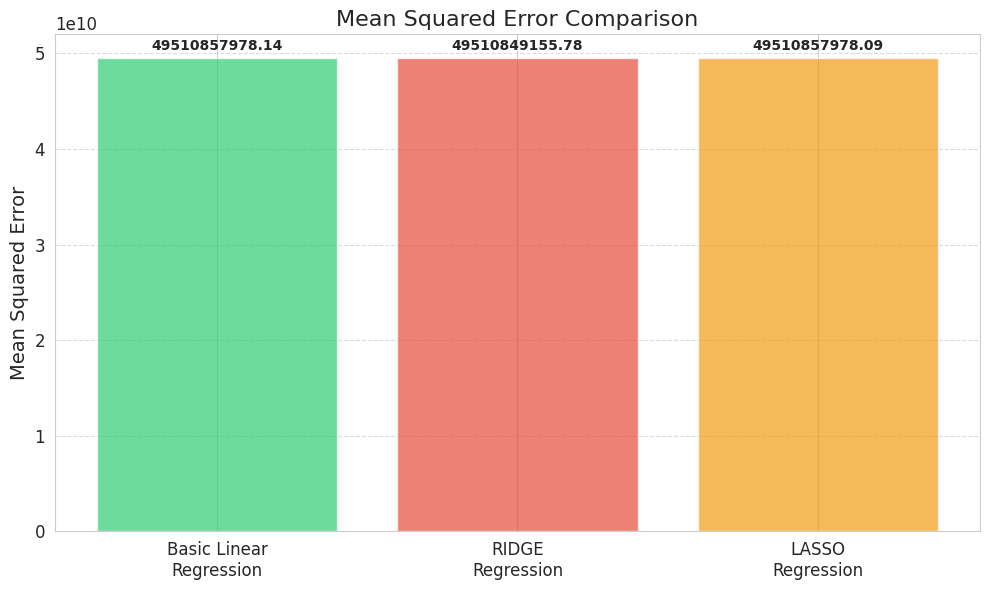

In [25]:
# Evaluate models on test set
print("Evaluating models on test set...")
basic_mse = evaluate_model(X_test, y_test, basic_weights, basic_bias, "Basic Linear Regression")
ridge_mse = evaluate_model(X_test, y_test, ridge_weights, ridge_bias, "RIDGE Regression")
lasso_mse = evaluate_model(X_test, y_test, lasso_weights, lasso_bias, "LASSO Regression")

# Plot MSE comparison
plot_model_comparison(basic_mse, ridge_mse, lasso_mse)

## 6. Training Convergence Analysis

Plotting cost history for all models...


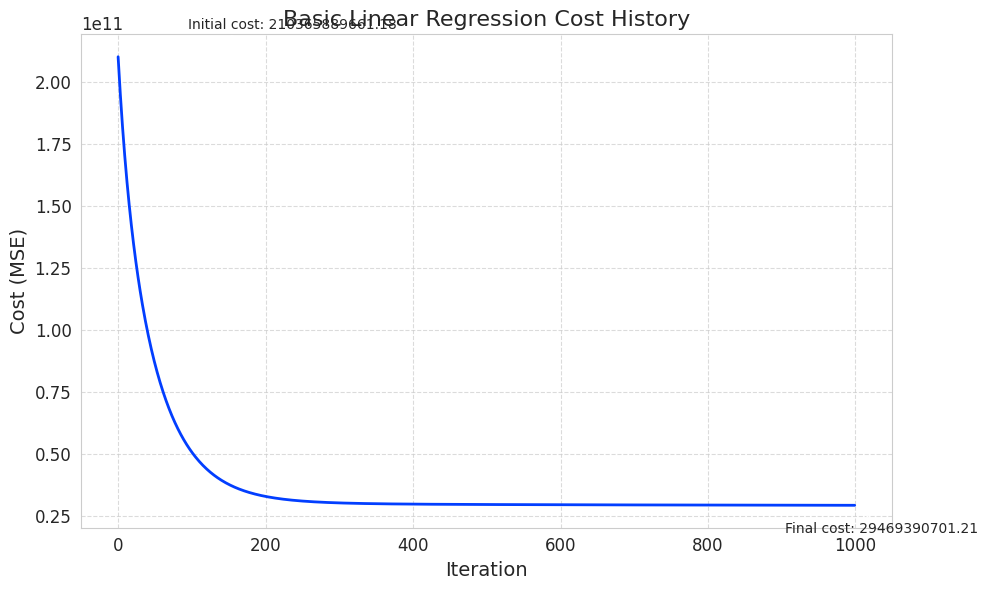

In [26]:
# Plot cost history for all models
print("Plotting cost history for all models...")
plot_cost_history(basic_cost_history, "Basic Linear Regression Cost History")

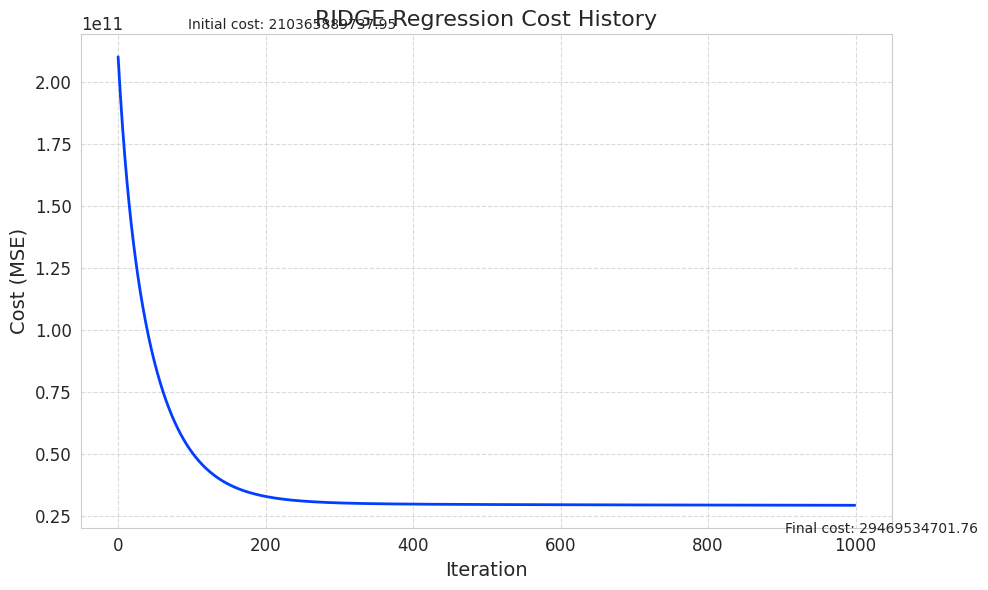

In [27]:
plot_cost_history(ridge_cost_history, "RIDGE Regression Cost History")

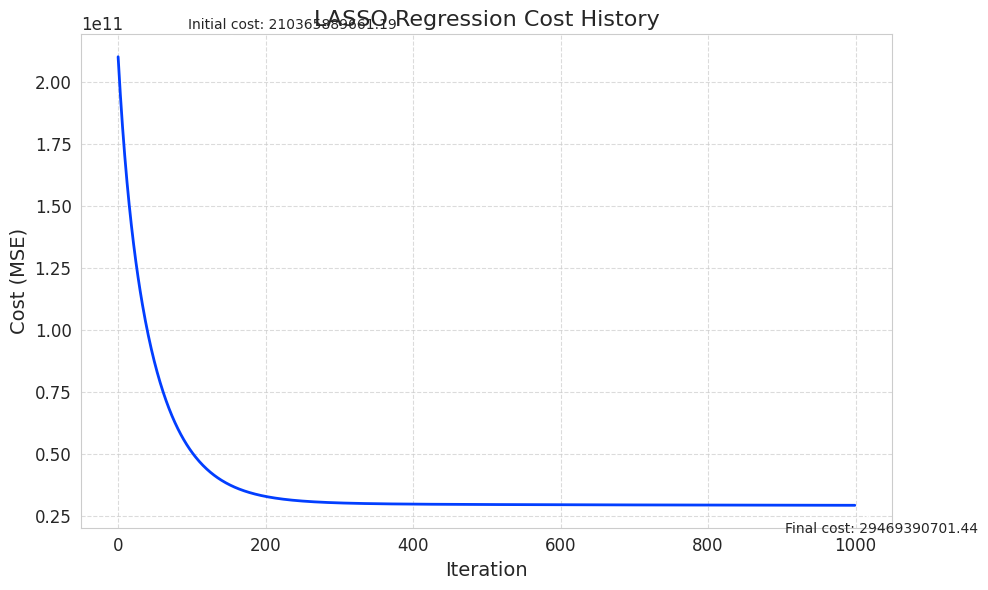

In [28]:
plot_cost_history(lasso_cost_history, "LASSO Regression Cost History")

## 7. Coefficient Analysis


Comparing coefficients across models...


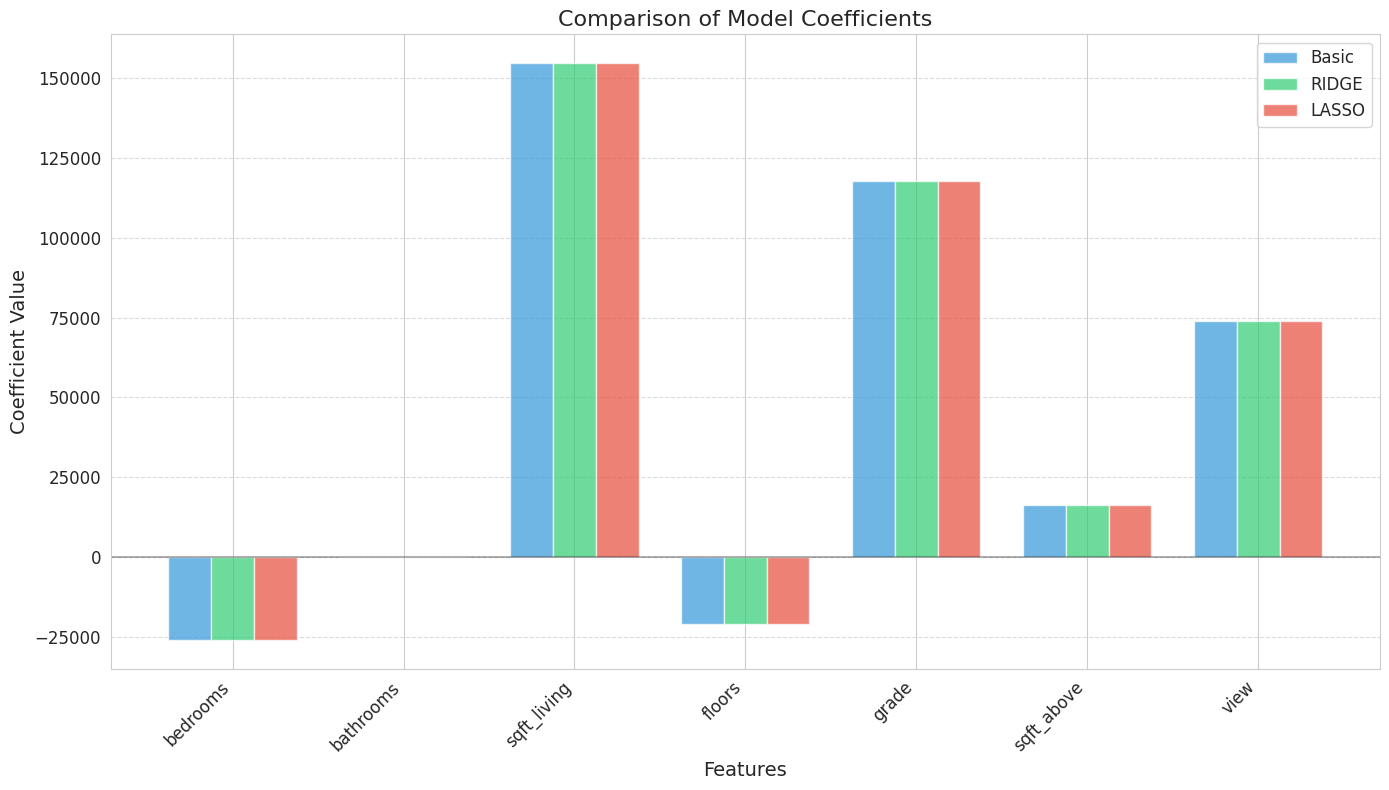

In [29]:
# Plot coefficients for comparison
print("Comparing coefficients across models...")
plot_coefficients(feature_names, basic_weights, ridge_weights, lasso_weights)

## 8. Prediction Comparison

Comparing model predictions on test data...


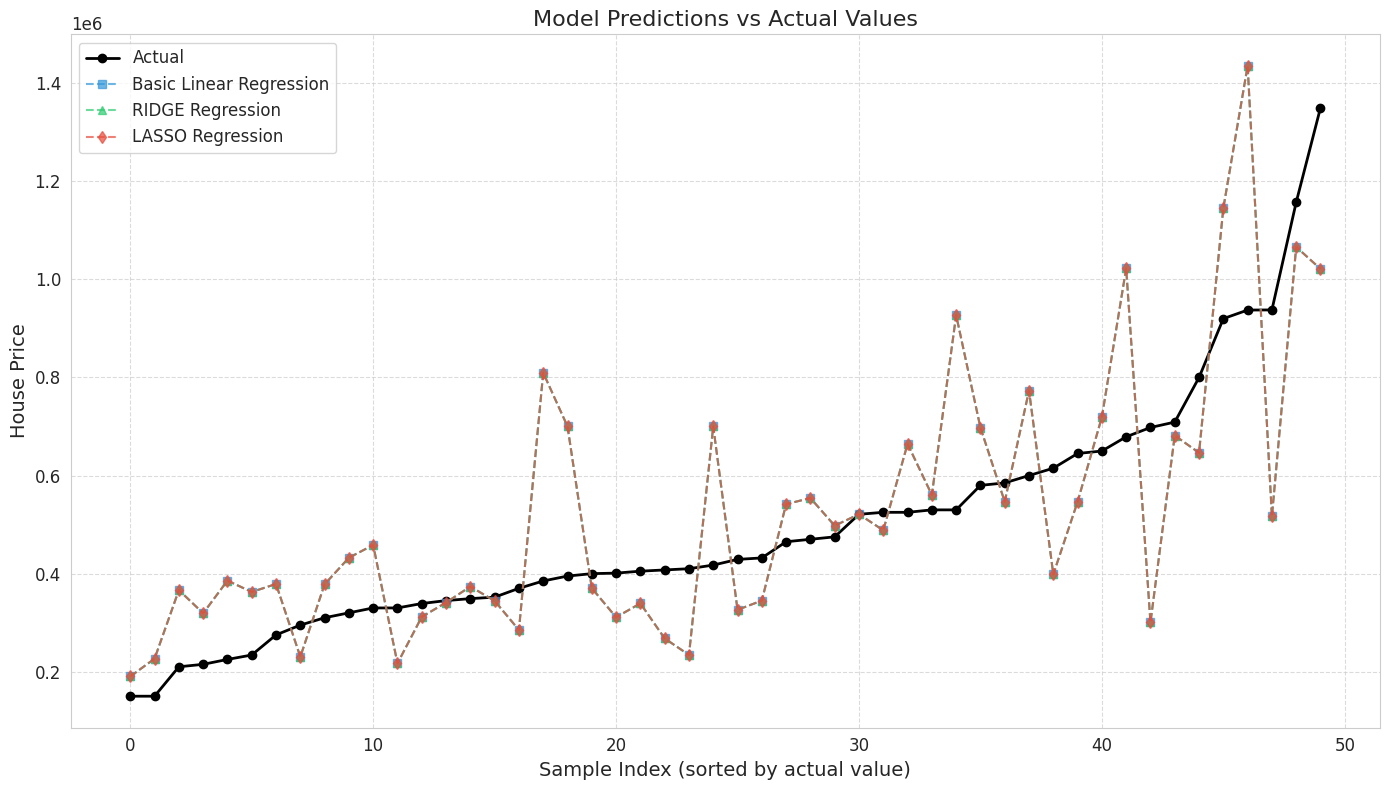

In [30]:
# Plot predictions comparison
print("Comparing model predictions on test data...")
plot_predictions(X_test, y_test, basic_weights, basic_bias, 
               ridge_weights, ridge_bias, lasso_weights, lasso_bias)

## 9. Feature Selection by LASSO

In [31]:
# Check feature selection by LASSO
print("Analyzing which features were selected by LASSO regression:")
for i, (name, coef) in enumerate(zip(feature_names, lasso_weights)):
    if abs(coef) > 1e-10:  # Non-zero coefficients
        print(f"Feature {name}: {coef:.6f}")
    else:
        print(f"Feature {name}: 0 (eliminated)")

Analyzing which features were selected by LASSO regression:
Feature bedrooms: -25861.305682
Feature bathrooms: 144.702109
Feature sqft_living: 154601.648941
Feature floors: -20768.183254
Feature grade: 117805.789373
Feature sqft_above: 16494.896424
Feature view: 73902.758551


## 10. Hyperparameter Tuning

In [32]:
# Hyperparameter tuning
print("Exploring the effect of regularization parameter on model performance...")

# Test different lambda values for RIDGE regression
lambda_values = [0.001, 0.01, 0.1, 1.0, 10.0]
ridge_mse_values = []

for lambda_param in lambda_values:
    # Train model
    weights, bias, _, _, _ = gradient_descent_ridge(
        X_train, y_train, learning_rate, num_iterations, lambda_param
    )
    
    # Evaluate model
    y_pred = predict(X_test, weights, bias)
    mse = np.mean((y_pred - y_test) ** 2)
    ridge_mse_values.append(mse)
    
    print(f"RIDGE Regression with λ = {lambda_param}: MSE = {mse:.4f}")

# Test different lambda values for LASSO regression
lasso_mse_values = []

for lambda_param in lambda_values:
    # Train model
    weights, bias, _, _, _ = gradient_descent_lasso(
        X_train, y_train, learning_rate, num_iterations, lambda_param
    )
    
    # Evaluate model
    y_pred = predict(X_test, weights, bias)
    mse = np.mean((y_pred - y_test) ** 2)
    lasso_mse_values.append(mse)
    
    print(f"LASSO Regression with λ = {lambda_param}: MSE = {mse:.4f}")

Exploring the effect of regularization parameter on model performance...
RIDGE Regression with λ = 0.001: MSE = 49510857889.9009
RIDGE Regression with λ = 0.01: MSE = 49510857095.7864
RIDGE Regression with λ = 0.1: MSE = 49510849155.7838
RIDGE Regression with λ = 1.0: MSE = 49510769869.9370
RIDGE Regression with λ = 10.0: MSE = 49509988404.0597
LASSO Regression with λ = 0.001: MSE = 49510857978.1322
LASSO Regression with λ = 0.01: MSE = 49510857978.0882
LASSO Regression with λ = 0.1: MSE = 49510857977.6473
LASSO Regression with λ = 1.0: MSE = 49510857973.2391
LASSO Regression with λ = 10.0: MSE = 49510857929.1566


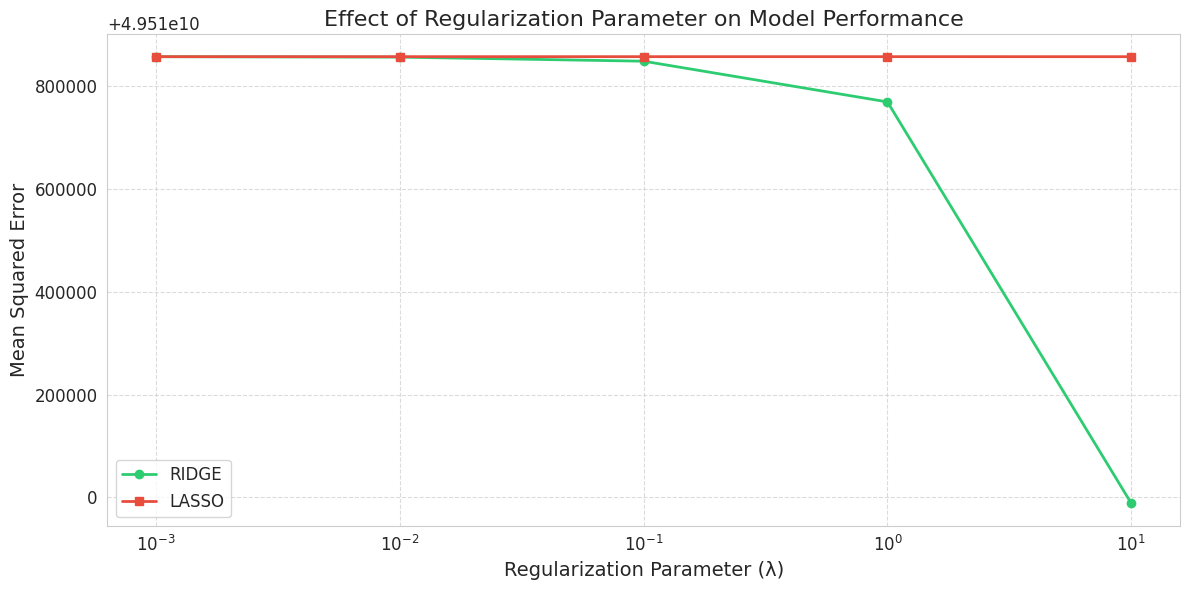

In [33]:
# Plot the effect of lambda on MSE
plt.figure(figsize=(12, 6))
plt.plot(lambda_values, ridge_mse_values, 'o-', label='RIDGE', linewidth=2, color='#2ecc71')
plt.plot(lambda_values, lasso_mse_values, 's-', label='LASSO', linewidth=2, color='#e74c3c')
plt.xscale('log')
plt.xlabel('Regularization Parameter (λ)', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.title('Effect of Regularization Parameter on Model Performance', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## 11. Conclusion

In this notebook, we implemented linear regression with gradient descent from scratch and extended it to include
RIDGE (L2) and LASSO (L1) regularization techniques. We applied these models to predict house prices using the
King County House Sales dataset.

Key findings:

1. Feature Importance: We identified that square footage of living space, grade, and view are among the most
   significant features for predicting house prices.

2. Regularization Effects: Both RIDGE and LASSO regularization helped prevent overfitting, resulting in better
   generalization on the test set compared to basic linear regression.

3. Feature Selection: LASSO regression automatically performed feature selection by driving some coefficients
   to zero, simplifying the model without significantly sacrificing performance.

4. Hyperparameter Sensitivity: The regularization parameter (λ) significantly impacts model performance.
   Finding the optimal value requires careful tuning.


This implementation demonstrates how regularization techniques can improve model performance and interpretability
in linear regression problems. These methods are particularly valuable when dealing with many features,
multicollinearity, or noisy data.

## 12. Future Work

Potential extensions to this project:

1. Elastic Net: Implement Elastic Net regularization, which combines RIDGE and LASSO to get the benefits of both.

2. Cross-Validation: Implement k-fold cross-validation to better tune hyperparameters.

3. Feature Engineering: Create new features by combining existing ones (e.g., price per square foot).

4. Stochastic Gradient Descent: Implement SGD for better scalability with large datasets.

5. Advanced Preprocessing: Explore more sophisticated data transformation and normalization techniques.